# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Fridge dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 49.4 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time


In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, SOA
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Fridge.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Fridge.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5036 - loss: 0.6932 - val_accuracy: 0.6856 - val_loss: 0.6920
Epoch 2/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5060 - loss: 0.6931 - val_accuracy: 0.6175 - val_loss: 0.6911
Epoch 3/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5200 - loss: 0.6919 - val_accuracy: 0.6158 - val_loss: 0.6903
Epoch 4/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5203 - loss: 0.6919 - val_accuracy: 0.6158 - val_loss: 0.6898
Epoch 5/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5220 - loss: 0.6919 - val_accuracy: 0.6158 - val_loss: 0.6893
Epoch 6/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5291 - loss: 0.6912 - val_accuracy: 0.6158 - val_loss: 0.6889
Epoch 7/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5272 - loss: 0.6913 - val_accuracy: 0.6158 - val_loss: 0.6887
Epoch 8/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5283 - loss: 0.6913 - val_accuracy:

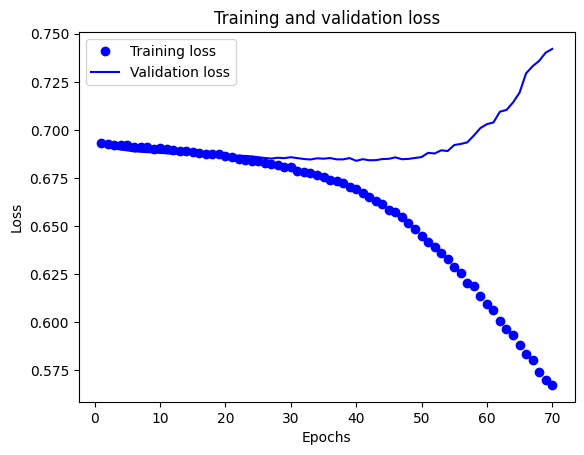

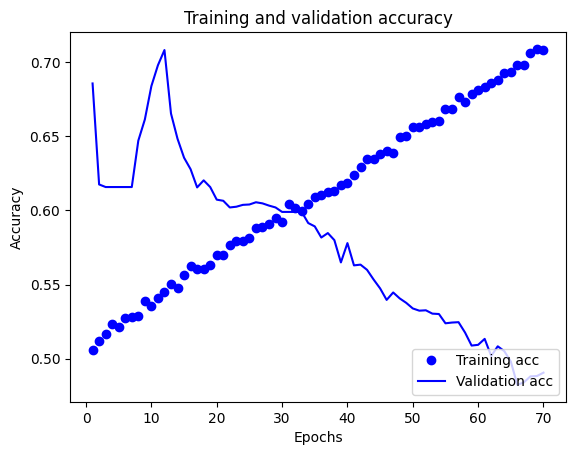


Classification Report
              precision    recall  f1-score   support

           0       0.41      0.79      0.54      1518
           1       0.71      0.31      0.43      2476

    accuracy                           0.49      3994
   macro avg       0.56      0.55      0.48      3994
weighted avg       0.59      0.49      0.47      3994


Confusion Matrix
[[1202  316]
 [1718  758]]


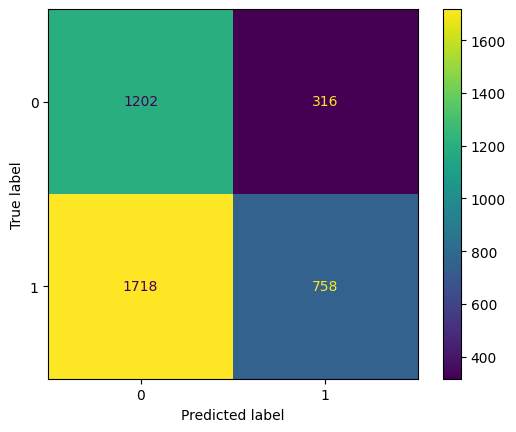

Time taken: 335.6792 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units



The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])


#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

#Dense Layer encoder
DENSE_ENCODER = LabelEncoder()
DENSE_ENCODER.fit([5, 8, 10])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]
  #dense_layers = DENSE_ENCODER.inverse_transform([int(params[5])])[0]
  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

  #for i in range(int(dense_layers)):
  #    model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
#LB = [0, 0, 0, 0, 0, 0]
#UB = [2.99, 6.99, 2.99, 2.99, 2.99, 2.99]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = SOA.OriginalSOA(epoch=15, pop_size=20, fc=2)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

#model.history.save_trajectory_chart(list_agent_idx=[3, 5, 6, 7,], selected_dimensions=[3, 4], filename="hello/tc")
# print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
# print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")

#print("\nConfusion Matrix")
#CHANGE ATTACK PREDICTION?
#print(confusion_matrix(y_test, attack_prediction))
#ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
#plt.show()

INFO:mealpy.bio_based.SOA.OriginalSOA:Solving single objective optimization problem.


Accuracy 0.2525656819343567
Accuracy 0.1226533055305481
Accuracy 0.30387985706329346
Accuracy 0.19474345445632935
Accuracy 0.6157697141170502
Accuracy 0.5709637105464935
Accuracy 0.46157699823379517
Accuracy 0.1499374508857727
Accuracy 0.2255319356918335
Accuracy 0.5677096247673035
Accuracy 0.3229036331176758
Accuracy 0.49336671829223633
Accuracy 0.3694618344306946
Accuracy 0.2653316855430603
Accuracy 0.54242804646492
Accuracy 0.6297872364521027
Accuracy 0.23604506254196167
Accuracy 0.6020025014877319
Accuracy 0.09762203693389893
Accuracy 0.03078848123550415
Accuracy 0.5118898749351501
Accuracy 0.29612016677856445
Accuracy 0.30688363313674927
Accuracy 0.6157697141170502
Accuracy 0.31739675998687744
Accuracy 0.2690863609313965
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.5952440500259399
Accuracy 0.2623279094696045
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.2

INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 1, Current best: 0.2623279094696045, Global best: 0.03078848123550415, Runtime: 2147.33047 seconds


Accuracy 0.29662078619003296
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.34392988681793213
Accuracy 0.313141405582428
Accuracy 0.3842303156852722
Accuracy 0.2803504467010498
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.30963706970214844
Accuracy 0.3036295175552368
Accuracy 0.29361701011657715
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 2, Current best: 0.2803504467010498, Global best: 0.03078848123550415, Runtime: 2025.10623 seconds


Accuracy 0.3021276593208313
Accuracy 0.3842303156852722
Accuracy 0.3138923645019531
Accuracy 0.3702127933502197
Accuracy 0.2565706968307495
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.29361701011657715
Accuracy 0.6157697141170502
Accuracy 0.2938673496246338
Accuracy 0.2963704466819763
Accuracy 0.6157697141170502
Accuracy 0.26783478260040283
Accuracy 0.3098873496055603
Accuracy 0.6157697141170502
Accuracy 0.3051314353942871
Accuracy 0.26558196544647217
Accuracy 0.3304130434989929
Accuracy 0.31113892793655396
Accuracy 0.6157697141170502


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 3, Current best: 0.2565706968307495, Global best: 0.03078848123550415, Runtime: 1516.32115 seconds


Accuracy 0.3842303156852722
Accuracy 0.009261548519134521
Accuracy 0.6157697141170502
Accuracy 0.2923654317855835
Accuracy 0.6157697141170502
Accuracy 0.3196495771408081
Accuracy 0.3842303156852722
Accuracy 0.27609509229660034
Accuracy 0.30137670040130615
Accuracy 0.6157697141170502
Accuracy 0.29411762952804565
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.28685855865478516
Accuracy 0.3842303156852722
Accuracy 0.0042552947998046875
Accuracy 0.2525656819343567
Accuracy 0.27859824895858765
Accuracy 0.2953692078590393
Accuracy 0.3083854913711548


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 4, Current best: 0.0042552947998046875, Global best: 0.0042552947998046875, Runtime: 1498.63583 seconds


Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.33541929721832275
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.3066332936286926
Accuracy 0.3186483383178711
Accuracy 0.2911139130592346
Accuracy 0.298623263835907
Accuracy 0.2838548421859741
Accuracy 0.33692115545272827
Accuracy 0.5684605836868286
Accuracy 0.3842303156852722
Accuracy 0.3103879690170288
Accuracy 0.3136420249938965
Accuracy 0.6157697141170502
Accuracy 0.28635793924331665
Accuracy 0.291864812374115
Accuracy 0.02327907085418701


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 5, Current best: 0.02327907085418701, Global best: 0.0042552947998046875, Runtime: 1430.26244 seconds


Accuracy 0.2793492078781128
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.277346670627594
Accuracy 0.6157697141170502
Accuracy 0.5249061286449432
Accuracy 0.29612016677856445
Accuracy 0.2963704466819763
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.31839799880981445
Accuracy 0.3113892078399658
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.3351689577102661
Accuracy 0.32265329360961914
Accuracy 0.3842303156852722


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 6, Current best: 0.277346670627594, Global best: 0.0042552947998046875, Runtime: 2037.34561 seconds


Accuracy 0.3842303156852722
Accuracy 0.3041301369667053
Accuracy 0.28210264444351196
Accuracy 0.260826051235199
Accuracy 0.3842303156852722
Accuracy 0.06708383560180664
Accuracy 0.27534419298171997
Accuracy 0.29987484216690063
Accuracy 0.306382954120636
Accuracy 0.3249061107635498
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.3947434425354004
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.299624502658844
Accuracy 0.2916145324707031
Accuracy 0.3842303156852722
Accuracy 0.26257824897766113
Accuracy 0.27183979749679565


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 7, Current best: 0.06708383560180664, Global best: 0.0042552947998046875, Runtime: 1506.83629 seconds


Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.32615768909454346
Accuracy 0.3842303156852722
Accuracy 0.29712140560150146
Accuracy 0.6157697141170502
Accuracy 0.2948685884475708
Accuracy 0.29461824893951416
Accuracy 0.3842303156852722
Accuracy 0.3204004764556885
Accuracy 0.6157697141170502
Accuracy 0.10362952947616577
Accuracy 0.2923654317855835
Accuracy 0.6157697141170502
Accuracy 0.3652064800262451
Accuracy 0.285106360912323
Accuracy 0.2793492078781128
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.2923654317855835


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 8, Current best: 0.10362952947616577, Global best: 0.0042552947998046875, Runtime: 1518.66624 seconds


Accuracy 0.3274092674255371
Accuracy 0.32665830850601196
Accuracy 0.28836047649383545
Accuracy 0.3066332936286926
Accuracy 0.28485608100891113
Accuracy 0.12740927934646606
Accuracy 0.6157697141170502
Accuracy 0.025782227516174316
Accuracy 0.28285354375839233
Accuracy 0.29937422275543213
Accuracy 0.3133917450904846
Accuracy 0.27959948778152466
Accuracy 0.2765957713127136
Accuracy 0.13216519355773926
Accuracy 0.3842303156852722
Accuracy 0.2665832042694092
Accuracy 0.24430537223815918
Accuracy 0.30037546157836914
Accuracy 0.3842303156852722
Accuracy 0.3166458010673523


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 9, Current best: 0.025782227516174316, Global best: 0.0042552947998046875, Runtime: 995.90832 seconds


Accuracy 0.31414270401000977
Accuracy 0.3842303156852722
Accuracy 0.15644556283950806
Accuracy 0.6157697141170502
Accuracy 0.2886107563972473
Accuracy 0.29737168550491333
Accuracy 0.31163954734802246
Accuracy 0.28986233472824097
Accuracy 0.2896119952201843
Accuracy 0.313141405582428
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.30488109588623047
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.3166458010673523
Accuracy 0.6157697141170502
Accuracy 0.3031288981437683
Accuracy 0.27183979749679565
Accuracy 0.24806004762649536


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 10, Current best: 0.15644556283950806, Global best: 0.0042552947998046875, Runtime: 1496.06683 seconds


Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.2856069803237915
Accuracy 0.3204004764556885
Accuracy 0.3842303156852722
Accuracy 0.28285354375839233
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.29762202501296997
Accuracy 0.5757196545600891
Accuracy 0.2981226444244385
Accuracy 0.3128911256790161
Accuracy 0.29211515188217163
Accuracy 0.3842303156852722
Accuracy 0.29361701011657715
Accuracy 0.2963704466819763
Accuracy 0.24280351400375366
Accuracy 0.10362952947616577
Accuracy 0.3842303156852722


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 11, Current best: 0.10362952947616577, Global best: 0.0042552947998046875, Runtime: 1641.75031 seconds


Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.278347909450531
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.2643303871154785
Accuracy 0.3842303156852722
Accuracy 0.3051314353942871
Accuracy 0.6157697141170502
Accuracy 0.28836047649383545
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.278347909450531
Accuracy 0.6157697141170502
Accuracy 0.28735917806625366
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.27859824895858765
Accuracy 0.28685855865478516


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 12, Current best: 0.2643303871154785, Global best: 0.0042552947998046875, Runtime: 1844.21339 seconds


Accuracy 0.2963704466819763
Accuracy 0.6157697141170502
Accuracy 0.32665830850601196
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.30713391304016113
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3128911256790161
Accuracy 0.3842303156852722
Accuracy 0.20625782012939453
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.26207756996154785


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 13, Current best: 0.20625782012939453, Global best: 0.0042552947998046875, Runtime: 2131.79650 seconds


Accuracy 0.31163954734802246
Accuracy 0.27709639072418213
Accuracy 0.6157697141170502
Accuracy 0.10938674211502075
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.284105122089386
Accuracy 0.0030037760734558105
Accuracy 0.058573246002197266
Accuracy 0.6157697141170502
Accuracy 0.29737168550491333
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.30763453245162964
Accuracy 0.2938673496246338
Accuracy 0.3429286479949951
Accuracy 0.28986233472824097
Accuracy 0.30337923765182495
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 14, Current best: 0.0030037760734558105, Global best: 0.0030037760734558105, Runtime: 1527.80078 seconds


Accuracy 0.260826051235199
Accuracy 0.09586983919143677
Accuracy 0.10262829065322876
Accuracy 0.12740927934646606
Accuracy 0.08285355567932129
Accuracy 0.07158946990966797
Accuracy 0.1173967719078064
Accuracy 0.07534420490264893
Accuracy 0.058322906494140625
Accuracy 0.09086358547210693
Accuracy 0.02327907085418701
Accuracy 0.08360451459884644
Accuracy 0.13366711139678955
Accuracy 0.12290364503860474
Accuracy 0.02703380584716797
Accuracy 0.13516896963119507
Accuracy 0.12290364503860474
Accuracy 0.19524407386779785
Accuracy 0.010763466358184814
Accuracy 0.02703380584716797


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 15, Current best: 0.010763466358184814, Global best: 0.0030037760734558105, Runtime: 700.17957 seconds


Accuracy 0.12715893983840942
Solution: [2.29882422 5.56406119 5.21991897 1.72729706 0.74742709], Fitness: 0.0030037760734558105
Solution: [2.29882422 5.56406119 5.21991897 1.72729706 0.74742709], Fitness: 0.0030037760734558105


Solution: [2.29882422 5.56406119 5.21991897 1.72729706 0.74742709], Fitness: 0.0030037760734558105


Batch Size - 32, 64, **128**

Activation - softmax, softplus, relu, tanh, sigmoid, **hard_sigmoid**, linear

Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, **0.1**

Filters - 25, **50**, 75

Hidden Units - **400**, 512, 640

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,241 (219.69 KB)

 Trainable params: 56,141 (219.30 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5026 - loss: 0.9352 - val_accuracy: 0.3842 - val_loss: 1.0431
Epoch 2/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4975 - loss: 0.9923 - val_accuracy: 0.3842 - val_loss: 1.3686
Epoch 3/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4964 - loss: 1.0021 - val_accuracy: 0.3842 - val_loss: 0.8795
Epoch 4/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5005 - loss: 0.9495 - val_accuracy: 0.6158 - val_loss: 0.7380
Epoch 5/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4933 - loss: 0.9865 - val_accuracy: 0.3842 - val_loss: 1.6315
Epoch 6/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5025 - loss: 0.9100 - val_accuracy: 0.6158 - val_loss: 0.9009
Epoch 7/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4998 - loss: 0.9346 - val_accuracy: 0.3842 - val_loss: 1.2524
Epoch 8/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4976 - loss: 0.9312 - val_accuracy: 0.

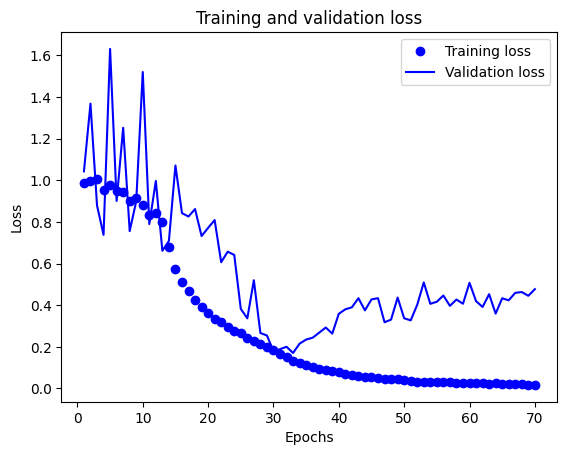

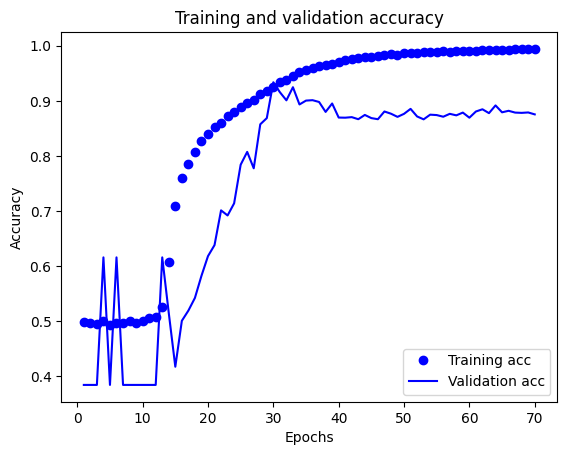


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1518
           1       0.84      1.00      0.91      2476

    accuracy                           0.88      3994
   macro avg       0.92      0.85      0.87      3994
weighted avg       0.90      0.88      0.88      3994


Confusion Matrix
[[1051  467]
 [   0 2476]]


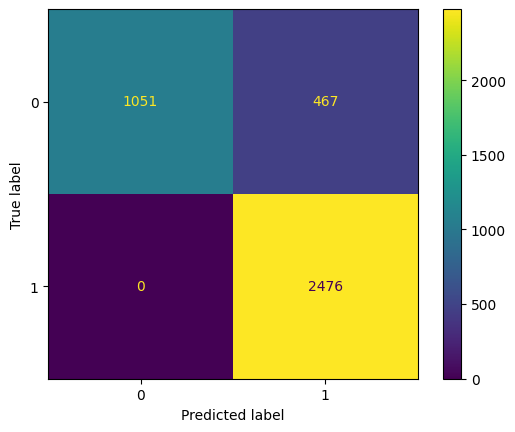

Time taken: 121.4266 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(400, activation='hard_sigmoid'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.1)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")